<a href="https://colab.research.google.com/github/tergll/Tergel_Portfolio/blob/main/Nail_classficiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Binary classification using transfer learning on MobileNetV2

## Nail Polish Quality Assessment Using Machine Learning

### Project Overview

This project aims to build a machine learning model that can assess the quality of gel nail polish application from images. Specifically, the model will classify nail polish quality into two categories: good and bad.
Good = no polish leaking into cuticle area, even shape, no peeling, uniform shape.
Bad = visibly leaking gel into the cuticle or weird brush strokes, uneven gel throughout the nail, peeling or wrongly cured gels, and shape is visibly uneven (less importance here since some designs intentionally have different shapes)
.
The model is more focused on the quality of the work in terms of even and clean application rather than judging based on the design itself.
By automating this evaluation process, the project has potential applications for both beauty enthusiasts and professionals who seek consistent, high-quality results in nail art. As a beginner nail tech, you don't yet have the eye for how it should look. Therefore, this model can help give feedback on whether your design needs improvement in terms of quality deliverable.

### Motivation

The idea for this project was inspired by the meticulous standards of nail art, where even minor imperfections like leaks or uneven edges can affect the overall quality. As a beginner nail artist, it is not always possible to ask for a professional opinion unless you enroll in a nail school. An AI-driven approach to nail polish assessment can provide an objective and quick evaluation, offering insights and suggestions that may enhance user experience and professional standards in the beauty industry.

### Dataset

The dataset used for this project comprises images of hands with gel nail polish, categorized into two classes based on application quality. The images come from a variety of sources including nail segmentation datasets from Roboflow to downloading images from google search including reddit posts in "Nails" group. Images were collected and labeled using Roboflow, following a "Folder Structure" format that organizes the dataset by class folders. This structure allows us to efficiently load and preprocess the data for model training.

Acknowdlegement: I labeled the images from my 4 years of experience in doing nails and reading a lot about it. The images were judged bad when there was visible peeling, leaking gel, bleeding of cuticles, uneven gel distribution, shape unevenness. Sometimes, there is a very thin line between what is good and what needs improvement and it depends on each nail artist's personal standards. In such cases, I labeled more on the positive side.


### Expected Outcomes

By the end of this project, we expect to have a working classification model capable of assessing gel nail polish quality. This could serve as a foundation for future enhancements, such as real-time feedback for DIY nail artists or quality monitoring tools for nail salons.

Let's get started!
This code was adapted from https://colab.research.google.com/drive/1bOzVaDQo8h6Ngstb7AcfzC35OihpHspt?usp=sharing&ref=blog.roboflow.com#scrollTo=I8ARiyMFsgbH

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Data preprocessing

### Data download

In [4]:
# !curl -L "https://public.roboflow.com/ds/[YOUR-KEY-HERE]" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
# %cd /content/
# %mkdir images/
# %mv train images/train
# %mv test images/test
# %mv valid images/valid



In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="UqbhNx9HG9tSoHwH6L8V")
project = rf.workspace("nail-salon").project("nail_salon")
version = project.version(1)
dataset = version.download("folder")
# %cd /content/nail_salon-1
# Unzip the downloaded roboflow.zip file into the 'nail_salon-1' directory
# !unzip -q roboflow.zip

# # List the contents of the extracted folder to check for train, test, and valid splits
# !ls nail_salon-1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to nail_salon-1 in folder:: 100%|██████████| 1028/1028 [00:00<00:00, 2882.16it/s]


We need to turn this dataset into a Tensorflow Dataset format.

In [6]:
import tensorflow_datasets as tfds

builder = tfds.folder_dataset.ImageFolder('/content/nail_salon-1')  # Adjust if the folder name differs
print(builder.info)

# Load train, test, and validation sets
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)


tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=40, num_shards=1>,
        'train': <SplitInfo num_examples=939, num_shards=1>,
        'valid': <SplitInfo num_examples=38, num_shards=1>,
    },
    citation="""""",
)


Show images and labels from the training set:

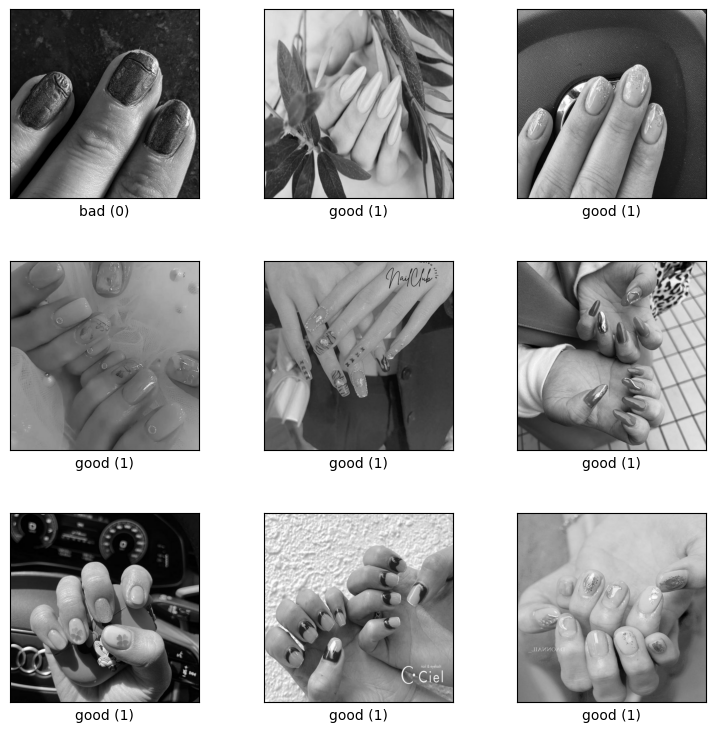

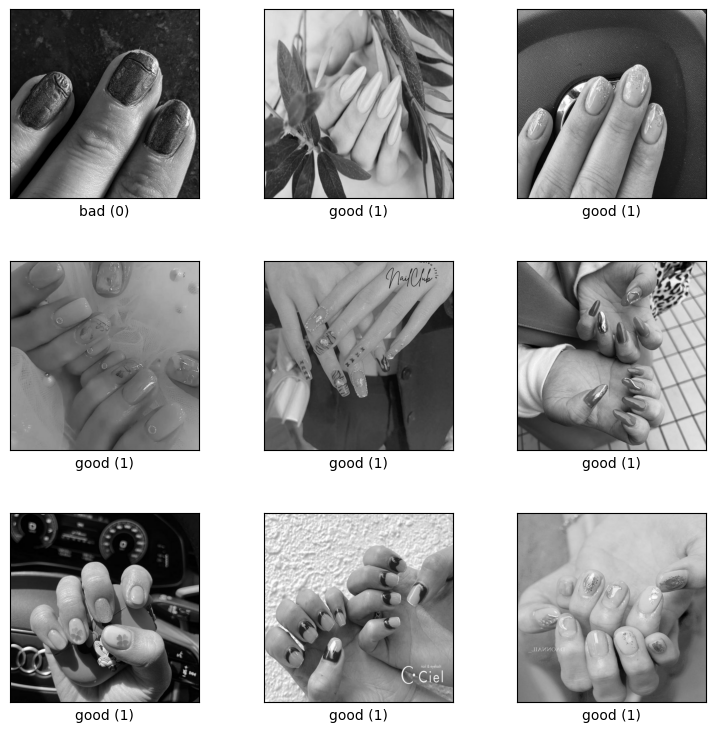

In [7]:
tfds.show_examples(raw_train, builder.info)

### Format the Data

We can use the `tf.image` module to format the images for the task.

Resize the images to a fixed input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [8]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

  return image, label

Apply this function to each item in the dataset using the map method:

In [9]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
test = raw_test.map(format_example)

Now shuffle and batch the data.

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [11]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Inspect a batch of data:

In [12]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## Create the base model from the pre-trained convnets

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [14]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [19]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# model.summary()

In [22]:
len(model.trainable_variables)

2

### Train the model

After training for 20 epochs, you should see ~90%+ accuracy.


In [23]:
initial_epochs = 30 #changed 20 to 30
validation_steps=30

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.6314 - loss: 0.5879


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.59
initial accuracy: 0.63


In [25]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.6420 - loss: 0.5487 - val_accuracy: 0.7632 - val_loss: 0.5289
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7836 - loss: 0.4858 - val_accuracy: 0.7895 - val_loss: 0.5172
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7613 - loss: 0.4840 - val_accuracy: 0.8158 - val_loss: 0.5077
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7762 - loss: 0.4928 - val_accuracy: 0.8158 - val_loss: 0.5036
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8003 - loss: 0.4341 - val_accuracy: 0.7895 - val_loss: 0.4974
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8047 - loss: 0.4503 - val_accuracy: 0.8158 - val_loss: 0.4843
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7907 - loss: 0.4490 - val_accuracy: 0.7895 - val_loss: 0.4767
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8163 - loss: 0.4217 - val_accuracy: 0.7895 -

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

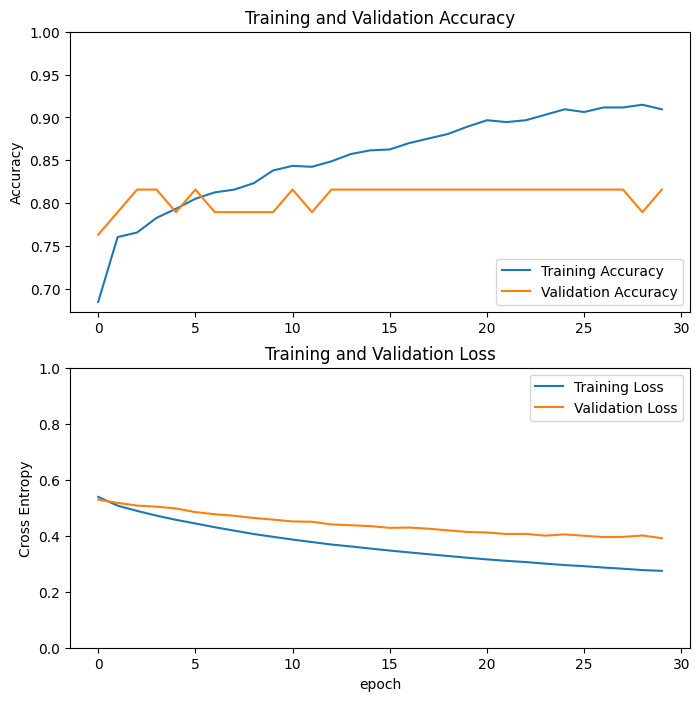

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

Compile the model using a much lower learning rate.

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [31]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 30/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 426ms/step - accuracy: 0.7725 - loss: 0.4075 - val_accuracy: 0.7895 - val_loss: 0.3896
Epoch 31/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.8663 - loss: 0.3186 - val_accuracy: 0.7895 - val_loss: 0.3871
Epoch 32/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9155 - loss: 0.2548 - val_accuracy: 0.7895 - val_loss: 0.3874
Epoch 33/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9456 - loss: 0.2190 - val_accuracy: 0.7895 - val_loss: 0.3826
Epoch 34/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9784 - loss: 0.1647 - val_accuracy: 0.8421 - val_loss: 0.3765
Epoch 35/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9878 - loss: 0.1268 - val_accuracy: 0.8421 - val_loss: 0.3634
Epoch 36/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9995 - loss: 0.0977 - val_accuracy: 0.8421 - val_loss: 0.3542
Epoch 37/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9991 - loss: 0.0711 - val_accuracy:

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

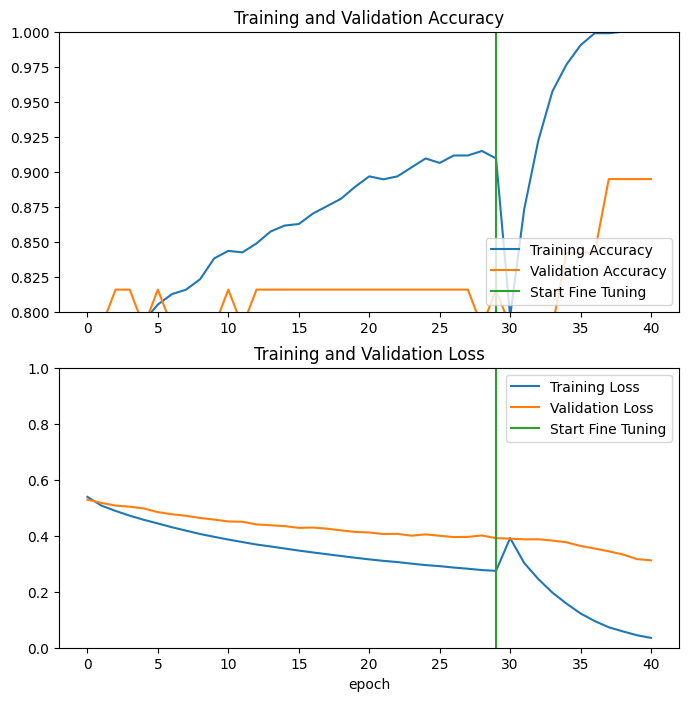

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Infer on a Sample Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Text(0.5, 1.0, 'Well done')

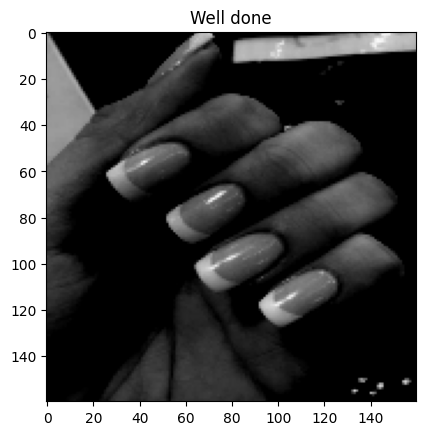

In [35]:
test_batches = test.batch(1)
for image, label in test_batches.take(1):
  pass
plt.imshow(np.squeeze(image))
plt.title("Well done" if model.predict(image) > 0 else "Needs some improvement")